In [24]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import EnergyScore, KernelScore, VariogramScore
from models import FNO_reparam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Subsampling rate
sampling_rate = 2
ntrain = 2000
ntest = 200
batch_size = 32

t_train= np.arange(5,20)
t_train_len = len(t_train)
t_eval = np.arange(20,35)
t_eval_len = len(t_eval)
data = np.load("data/ks_1d_data.npy").astype(np.float32)

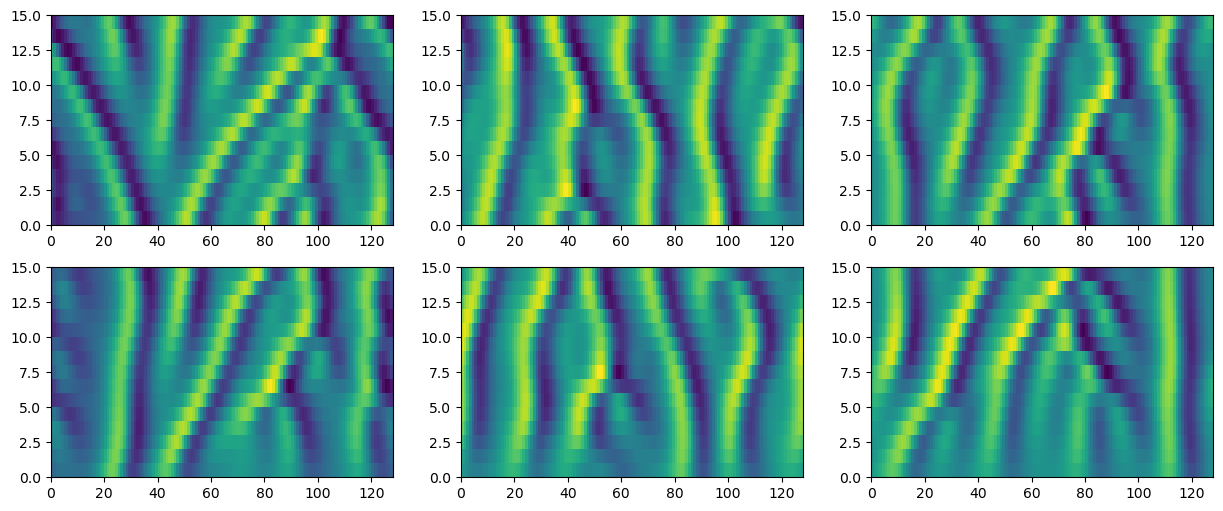

In [26]:
# Example plot
n_samples = np.random.randint(0,ntrain,3)

fig, axs = plt.subplots(2, 3, figsize = (15,6))
for i, sample in enumerate(n_samples):
    axs[1,i].pcolormesh(data[sample, t_train])
    axs[0,i].pcolormesh(data[sample, t_eval])

In [27]:
grid_range = 1

x_data = torch.tensor(data[:,t_train])
y_data = torch.tensor(data[:,t_eval])
x_data = (x_data - x_data.mean(dim = (0,2), keepdim=True)) / x_data.std(dim = (0,2), keepdim=True)
y_data = (y_data - y_data.mean(dim = (0,2), keepdim=True)) / y_data.std(dim = (0,2), keepdim=True)
size_x = x_data.shape[2]
size_x_train = int(size_x/sampling_rate)

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain,:,:,::sampling_rate], y_data[:ntrain,:,:,::sampling_rate]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx_train = torch.tensor(np.linspace(0, grid_range, size_x_train), dtype=torch.float)
gridx_train = gridx_train.reshape(1, 1, 1, size_x_train)
gridx_test = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx_test = gridx_test.reshape(1, 1, 1, size_x)


x_train = torch.cat((x_train, gridx_train.repeat([ntrain, 1, t_train_len,1])), dim=1)
x_test = torch.cat((x_test, gridx_test.repeat([ntest, 1, t_train_len,1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [28]:
l2loss = LpLoss(d=2, p=2, L = [10.0,50.0])
energy_score = EnergyScore(d = 2, p = 2, type = "lp", L = [10.0,50.0])
#energy_score = KernelScore(d=2, p=2, type = "lp",  L = [10.0,50.0], kernel ="laplace", gamma = 20)


# Training parameters
epochs = 25
learning_rate = 0.0007
dropout_rate = 0.2

# MC dropout

In [29]:
def generate_mc_samples(model, x, shape, n_samples=100):
    samples = torch.zeros(*shape, n_samples)
    for i in range(n_samples):
        with torch.no_grad():
            samples[...,i] = model(x).detach()
    return samples

In [30]:
model = FNO(n_modes=(8,16), hidden_channels=64, projection_channels=32,
             in_channels = 2, use_mlp=True, mlp_dropout=dropout_rate)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 2412289 parameters.


In [31]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [32]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-1.7156, Train-MSE-0.9685, Train-L2-0.0310, Test-L2-0.0332
Epoch-1, Time-1.3267, Train-MSE-0.8097, Train-L2-0.0283, Test-L2-0.0299
Epoch-2, Time-1.5714, Train-MSE-0.7011, Train-L2-0.0263, Test-L2-0.0285
Epoch-3, Time-1.7072, Train-MSE-0.6473, Train-L2-0.0253, Test-L2-0.0281
Epoch-4, Time-1.6856, Train-MSE-0.6048, Train-L2-0.0245, Test-L2-0.0271
Epoch-5, Time-1.6460, Train-MSE-0.5723, Train-L2-0.0238, Test-L2-0.0263
Epoch-6, Time-1.7123, Train-MSE-0.5441, Train-L2-0.0232, Test-L2-0.0266
Epoch-7, Time-1.6841, Train-MSE-0.5261, Train-L2-0.0228, Test-L2-0.0261
Epoch-8, Time-1.7059, Train-MSE-0.5037, Train-L2-0.0223, Test-L2-0.0256
Epoch-9, Time-1.7232, Train-MSE-0.4884, Train-L2-0.0220, Test-L2-0.0254
Epoch-10, Time-1.6204, Train-MSE-0.4733, Train-L2-0.0216, Test-L2-0.0253
Epoch-11, Time-1.5819, Train-MSE-0.4602, Train-L2-0.0213, Test-L2-0.0250
Epoch-12, Time-1.5983, Train-MSE-0.4486, Train-L2-0.0211, Test-L2-0.0251
Epoch-13, Time-1.7115, Train-MSE-0.4343, Train-L2-0.0207, Tes

In [34]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = generate_mc_samples(model, x, y.shape, n_samples=50)
        pred.append(out)



pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, t_eval_len, size_x), y_test.view(-1, t_eval_len, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.4779151976108551
ES: 13.25474739074707


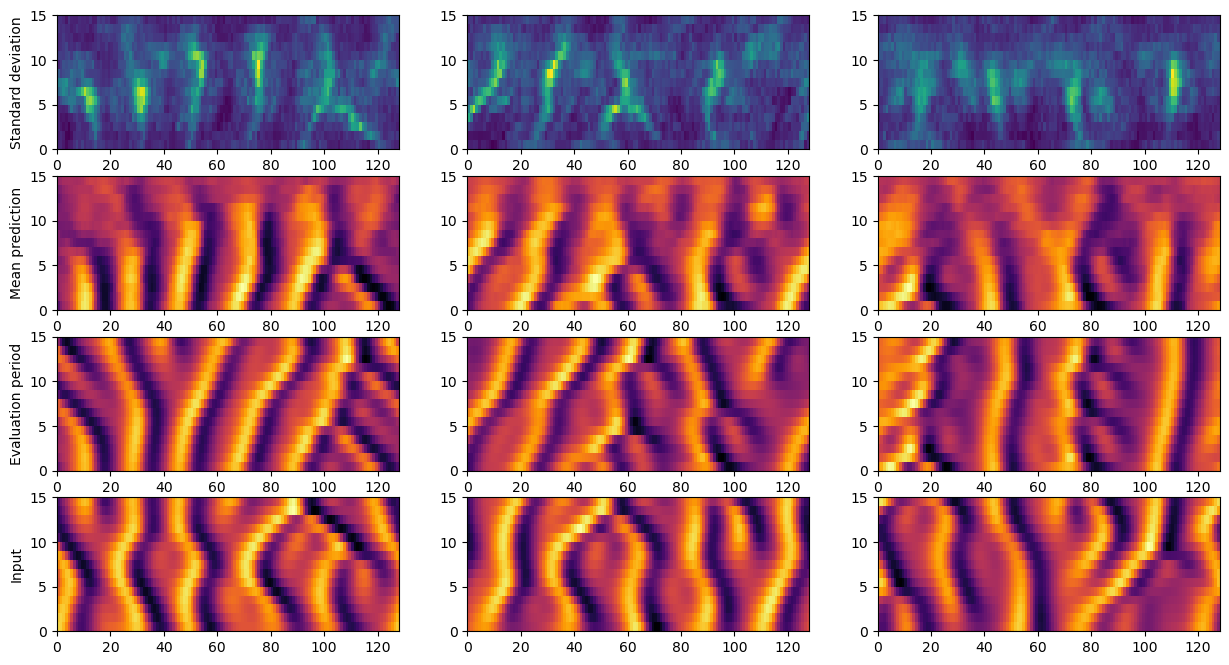

In [35]:
# Example plot
n_samples = np.random.randint(0,ntest,3)

fig, axs = plt.subplots(4, 3, figsize = (15,8))
for i, sample in enumerate(n_samples):
    axs[3,i].pcolormesh(x_test[sample,0], cmap = "inferno")
    axs[2,i].pcolormesh(y_test[sample,0], cmap = "inferno")
    axs[1,i].pcolormesh(pred[sample,0].mean(axis = -1), cmap = "inferno")
    axs[0,i].pcolormesh(pred[sample,0].std(axis = -1))

labels = ["Input", "Evaluation period", "Mean prediction", "Standard deviation"]

for i in range(4):
    axs[i,0].set_ylabel(labels[3-i])

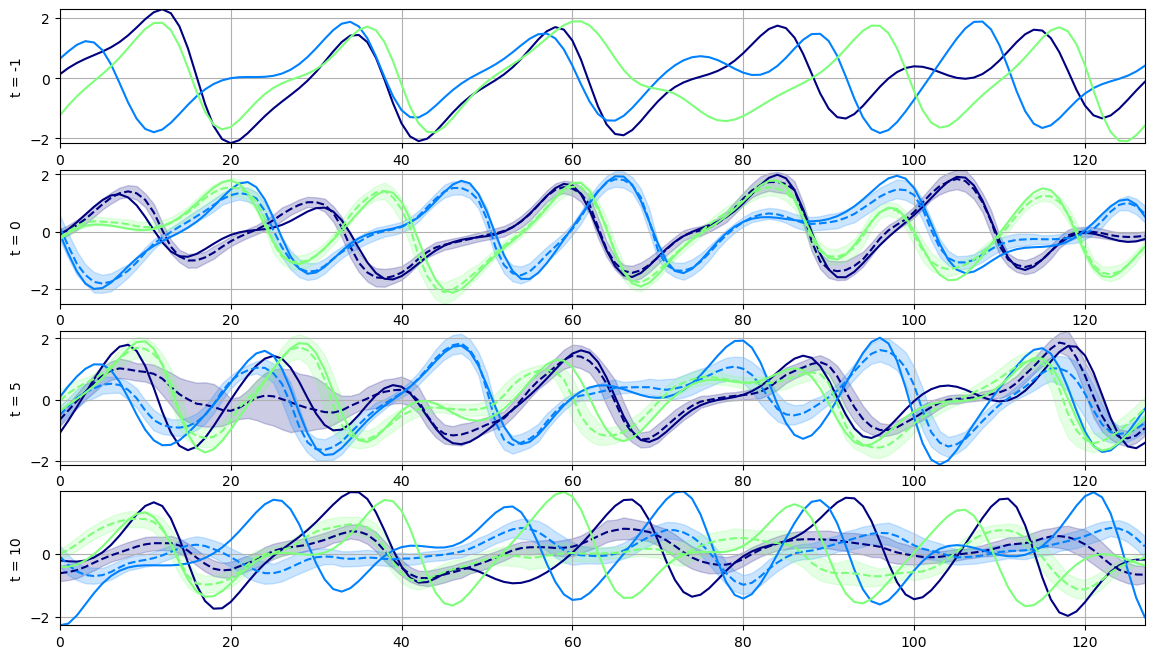

In [ ]:
# Example plot
n_samples = np.random.randint(0,ntest,3)

colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(4, 1, figsize = (14, 8))
for i, sample in enumerate(n_samples):
    axs[0].plot(x_test[i,0, 4], color=colors[i], label='Actual')
    axs[0].set_ylabel("t = -1")
    t = 0
    axs[1].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[1].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[1].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[1].set_ylabel(f"t = {t}")
    t = 5
    axs[2].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[2].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[2].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[2].set_ylabel(f"t = {t}")
    t = 10
    axs[3].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[3].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[3].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[3].set_ylabel(f"t = {t}")

for i in range(4):
    axs[i].grid(True)
    axs[i].margins(0)

# PFNO

In [ ]:
sample_model = FNO_reparam(n_modes=(8,16), hidden_channels=64, projection_channels=32, in_channels=2, n_samples = 25,
                           use_mlp=True, mlp_dropout=0.05)
sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [ ]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-1.4141, Train-L2-0.2538, Test-L2-0.3076
Epoch-1, Time-1.3592, Train-L2-0.2430, Test-L2-0.2934
Epoch-2, Time-1.3607, Train-L2-0.2286, Test-L2-0.2749
Epoch-3, Time-1.3382, Train-L2-0.2159, Test-L2-0.2641
Epoch-4, Time-1.3384, Train-L2-0.2076, Test-L2-0.2564
Epoch-5, Time-1.3299, Train-L2-0.2015, Test-L2-0.2493
Epoch-6, Time-1.3295, Train-L2-0.1955, Test-L2-0.2444
Epoch-7, Time-1.3413, Train-L2-0.1904, Test-L2-0.2415
Epoch-8, Time-1.3266, Train-L2-0.1865, Test-L2-0.2386
Epoch-9, Time-1.3294, Train-L2-0.1828, Test-L2-0.2383
Epoch-10, Time-1.3280, Train-L2-0.1802, Test-L2-0.2325
Epoch-11, Time-1.3192, Train-L2-0.1768, Test-L2-0.2299
Epoch-12, Time-1.3181, Train-L2-0.1739, Test-L2-0.2287
Epoch-13, Time-1.3299, Train-L2-0.1714, Test-L2-0.2268
Epoch-14, Time-1.3273, Train-L2-0.1696, Test-L2-0.2271
Epoch-15, Time-1.3368, Train-L2-0.1674, Test-L2-0.2252
Epoch-16, Time-1.3222, Train-L2-0.1656, Test-L2-0.2254
Epoch-17, Time-1.3261, Train-L2-0.1636, Test-L2-0.2241
Epoch-18, Time-1.326

In [ ]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = sample_model(x, n_samples = 500).detach().cpu()
        pred.append( out )


pred = torch.cat((pred))
mse = F.mse_loss(pred.mean(axis = -1).view(-1, t_train_len, size_x), y_test.view(-1, t_train_len, size_x)).item()
es = energy_score(pred, y_test).item()

print('MSE:', mse)
print('ES:', es)

MSE: 0.49150320887565613
ES: 11.052355766296387


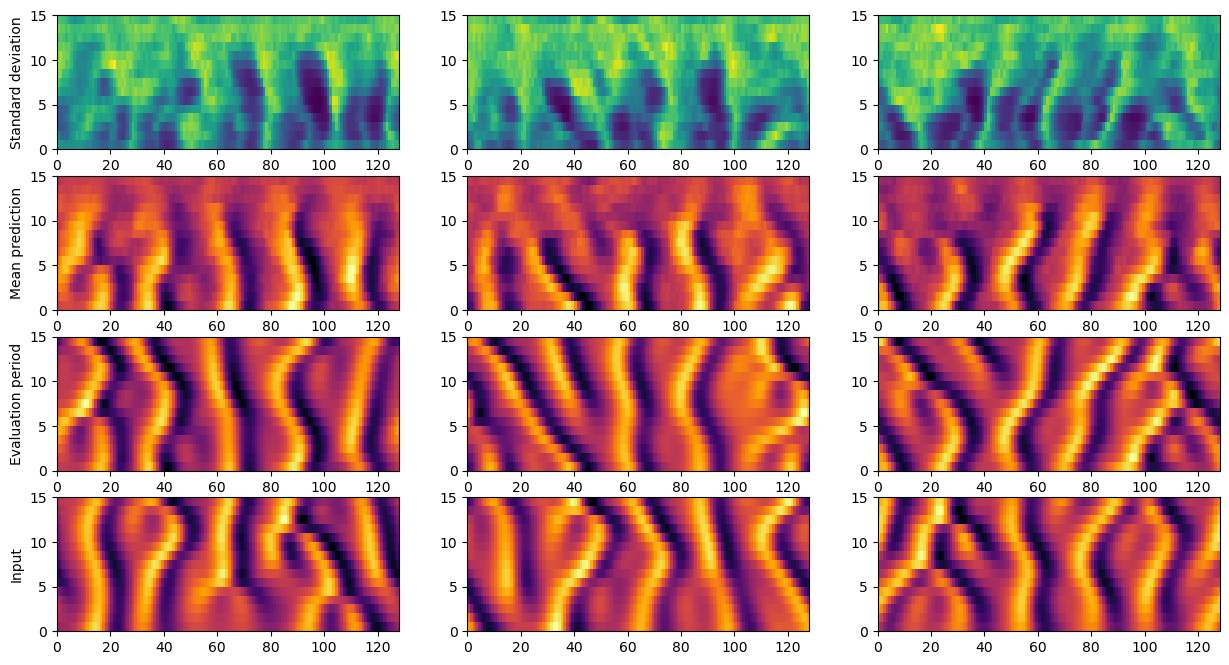

In [ ]:
# Example plot
n_samples = np.random.randint(0,ntest,3)

fig, axs = plt.subplots(4, 3, figsize = (15,8))
for i, sample in enumerate(n_samples):
    axs[3,i].pcolormesh(x_test[sample,0], cmap = "inferno")
    axs[2,i].pcolormesh(y_test[sample,0], cmap = "inferno")
    axs[1,i].pcolormesh(pred[sample,0].mean(axis = -1), cmap = "inferno")
    axs[0,i].pcolormesh(pred[sample,0].std(axis = -1))

labels = ["Input", "Evaluation period", "Mean prediction", "Standard deviation"]

for i in range(4):
    axs[i,0].set_ylabel(labels[3-i])

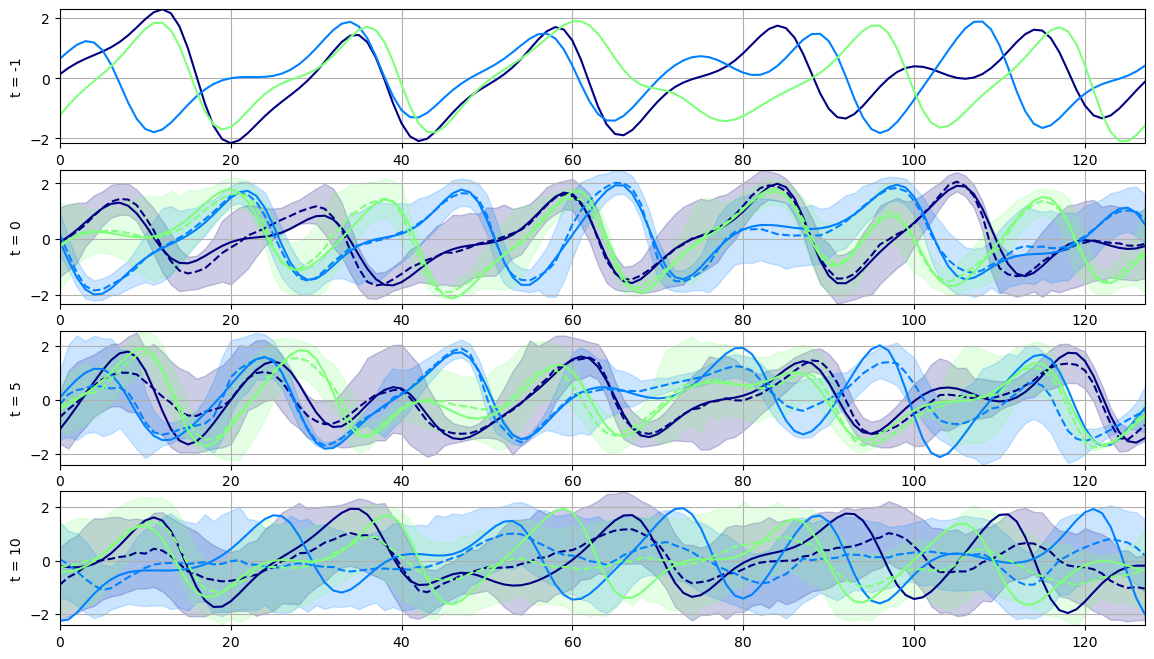

In [ ]:
# Example plot
n_samples = np.random.randint(0,ntest,3)

colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(4, 1, figsize = (14, 8))
for i, sample in enumerate(n_samples):
    axs[0].plot(x_test[i,0, 4], color=colors[i], label='Actual')
    axs[0].set_ylabel("t = -1")
    t = 0
    axs[1].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[1].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[1].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[1].set_ylabel(f"t = {t}")
    t = 5
    axs[2].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[2].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[2].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[2].set_ylabel(f"t = {t}")
    t = 10
    axs[3].plot(y_test[i, 0, t], color=colors[i], label='Actual')
    axs[3].plot(pred[i,0, t].mean(axis = -1).cpu().numpy(), '--', color=colors[i], label='Prediction')
    axs[3].fill_between(np.arange(0, size_x), pred[i,0,t].quantile(0.025, axis = -1),
                        pred[i,0,t].quantile(0.975, axis = -1) , color=colors[i], alpha=0.2)
    axs[3].set_ylabel(f"t = {t}")

for i in range(4):
    axs[i].grid(True)
    axs[i].margins(0)

In [ ]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

MSE-Dropout: 0.49541792273521423
ES-Dropout: 13.651206016540527
MSE: 0.49150320887565613
ES: 11.052355766296387
